In [1]:
from torch.utils.data import DataLoader

In [2]:
from mantisshrimp.all import *
import albumentations as A

In [3]:
source = Path('../nbs/samples').absolute()
annot_json = json.load((source/'annotations.json').open())

In [4]:
parser = COCOParser(annot_json, source/'images')
records = parser.parse()


Removed 0 images that don't have annotations


In [5]:
id2cat = {o['id']:o['name'] for o in annot_json['categories']}

In [7]:
record = records[-1]
# show_record(record, figsize=(10,10))

In [7]:
aug = AlbumentationTransformer([A.HorizontalFlip(p=1)])

In [8]:
class MyDataset:
    def __init__(self, records, tfms): self.records,self.tfms = records,tfms
    def __len__(self): return len(self.records)
    def __getitem__(self, i):
        im,rec = self.tfms(self.records[i])
        return im2tensor(im), rec.to_rcnn_target()

In [9]:
ds = MyDataset(records, aug)

In [10]:
def zip_collate(t): return tuple(zip(*t))

In [11]:
dl = DataLoader(ds, 2, shuffle=True, num_workers=0, collate_fn=zip_collate)

In [12]:
import pytorch_lightning as pl
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

class Model(pl.LightningModule):
    def __init__(self, n_class):
        super().__init__()
        self.m = self.get_model_instance_segmentation(n_class)
        
    def forward(self, x): return self.m(x)
    
    def training_step(self, b, b_idx):
        x,y = b
        losses = self.m(x,list(y))
        loss = sum(losses.values())
        return {'loss': loss, 'log': losses}
        
    def get_model_instance_segmentation(self, n_class, h=256):
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_class)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, h, n_class)
        return model
    
    def prepare_data(self): pass
        
    def configure_optimizers(self):
        params = [p for p in model.parameters() if p.requires_grad]
        opt = torch.optim.SGD(params, 5e-3, momentum=0.9, weight_decay=0.0005)
        step_lr = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
        return [opt], [step_lr]

In [13]:
model = Model(2)

In [17]:
trainer = pl.Trainer(max_epochs=2, gpus=1)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [18]:
trainer.fit(model, train_dataloader=dl)

INFO:lightning:
    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


1

In [12]:
xb,yb = first(dl)

In [7]:
im, r = aug(record)

In [8]:
tim = im2tensor(im)
target = r.to_rcnn_target()

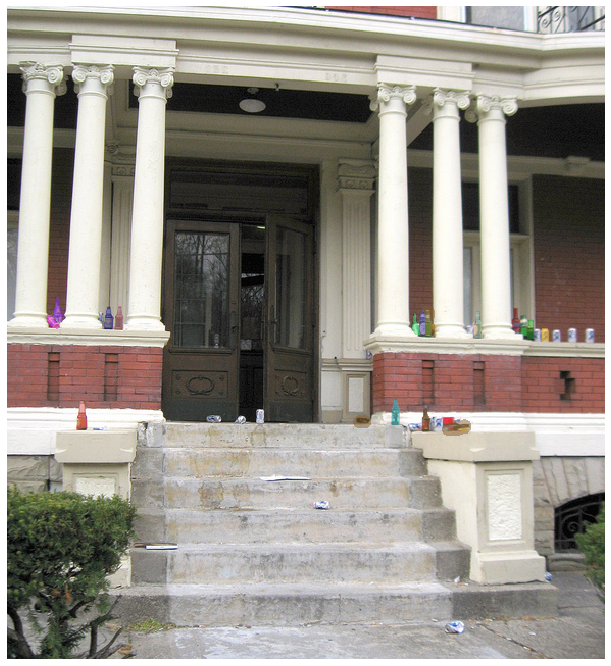

In [10]:
show_record(r, im=im, id2cat=id2cat, figsize=(12,12), bbox=False)